In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

# 1. Dataset
- Binary Classification Cat vs non-cat Images


In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
train_y = train_y.reshape(-1)
test_y = test_y.reshape(-1)

print(f'{train_x_orig.shape = }', f'{train_y.shape = }')
print(f'{test_x_orig.shape = }', f'{test_y.shape = }')

train_x_orig.shape = (209, 64, 64, 3) train_y.shape = (209,)
test_x_orig.shape = (50, 64, 64, 3) test_y.shape = (50,)


#### View

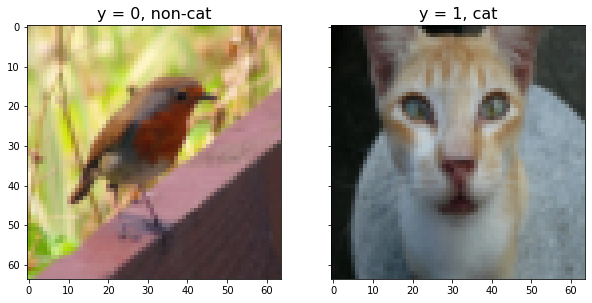

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

index = 10
label = 'non-cat' if (train_y[index] == 0) else 'cat'
axs[0].imshow(train_x_orig[index])
axs[0].set_title(f'y = {train_y[index]}, {label}', size=16)

index = 11
label = 'non-cat' if (train_y[index] == 0) else 'cat'
axs[1].imshow(train_x_orig[index])
axs[1].set_title(f'y = {train_y[index]}, {label}', size=16)

plt.show()

#### Flatten

In [4]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

#### Normalization

In [5]:
train_x_flatten = train_x_flatten/255.
test_x_flatten = test_x_flatten/255.

In [6]:
print(f'{train_x_flatten.shape = }', f'{train_y.shape = }')
print(f'{test_x_flatten.shape = }', f'{test_y.shape = }')

train_x_flatten.shape = (209, 12288) train_y.shape = (209,)
test_x_flatten.shape = (50, 12288) test_y.shape = (50,)


# 2. NN by torch

In [7]:
import torch
import torch.nn as nn

In [8]:
class MultiLayer_FC(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.L1_fc = nn.Linear(input_dim, 512)
        self.L1_act = nn.ReLU()

        self.L2_fc = nn.Linear(512, 256)
        self.L2_act = nn.ReLU()

        self.L3_fc = nn.Linear(256, 128)
        self.L3_act = nn.ReLU()

        self.L4_fc = nn.Linear(128, 64)
        self.L4_act = nn.Tanh()

        self.L5_fc = nn.Linear(64, output_dim)
        self.L5_act = nn.Sigmoid()

    def forward(self, X):
        Z1 = self.L1_fc(X)
        A1 = self.L1_act(Z1)

        Z2 = self.L2_fc(A1)
        A2 = self.L2_act(Z2)

        Z3 = self.L3_fc(A2)
        A3 = self.L3_act(Z3)

        Z4 = self.L4_fc(A3)
        A4 = self.L4_act(Z4)

        Z5 = self.L5_fc(A4)
        A5 = self.L5_act(Z5)
        return A5

# 3. Train

In [9]:
from torch.utils.data import TensorDataset, DataLoader
import os

def fit(
        X, Y,
        alpha=1e-2, num_iters=1000):
    """
    Train Fully Connected NN - 2 Layer - Binary Classification

    Arguments:
        X : input data of shape (m, input_dim)
        Y : labels 0,1 vector of shape (m,)

    Returns:
        J_history : History of Cost function for plotting
    """
    m, input_dim = X.shape
    output_dim = 1

    # Dataset
    dset = TensorDataset(
        torch.Tensor(X),
        torch.Tensor(Y))

    # Dataloader
    dloader = DataLoader(
        dataset=dset,
        batch_size=m)

    ## Config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = MultiLayer_FC(
        input_dim=input_dim,
        output_dim=output_dim)
    model = model.to(device)
    model.train()

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    # cost and params history
    J_history = []
    best_cost = float('inf')
    for i in range(num_iters):
        cost = 0
        # Batch: X_b = (batch_size, feats) y_b = (batch_size,)
        for b, batch in enumerate(dloader):
            Xb, Yb = batch
            Xb = Xb.to(device).float()
            Yb = Yb.to(device).to(torch.float32).unsqueeze(dim=1)

            # Forward
            optimizer.zero_grad()
            Yb_hat = model(Xb)

            # train loss
            cost_b = criterion(Yb_hat, Yb)
            # Track Cost
            cost += cost_b.item()

            # Back Propagation
            cost_b.backward()
            optimizer.step()

        # Compute Cost
        J_history.append(cost)
        if i % 200 == 0 or i == num_iters-1:
            # Save model
            if cost < best_cost:
                best_cost = cost

                # torch.save(model, f"ckpts/model_3C_NN_FC_multi_Layers_torch.ckpt")
                if not os.path.exists('ckpts/'): os.makedirs('ckpts/')
                checkpoint = {
                    'epoch': i,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                torch.save(checkpoint, f"ckpts/ckpt_3C_NN_FC_multi_Layers_torch.ckpt")

            # Progress
            print("Cost after iteration %i: %f" % (i, cost))
    return checkpoint, J_history

In [10]:
checkpoint, J_hist = fit(
    X=train_x_flatten , Y=train_y,
    alpha=1e-5, num_iters=1500)

Cost after iteration 0: 0.716179
Cost after iteration 200: 0.489027
Cost after iteration 400: 0.126461
Cost after iteration 600: 0.039895
Cost after iteration 800: 0.023025
Cost after iteration 1000: 0.016939
Cost after iteration 1200: 0.013803
Cost after iteration 1400: 0.011860
Cost after iteration 1499: 0.011145


#### Training param plot

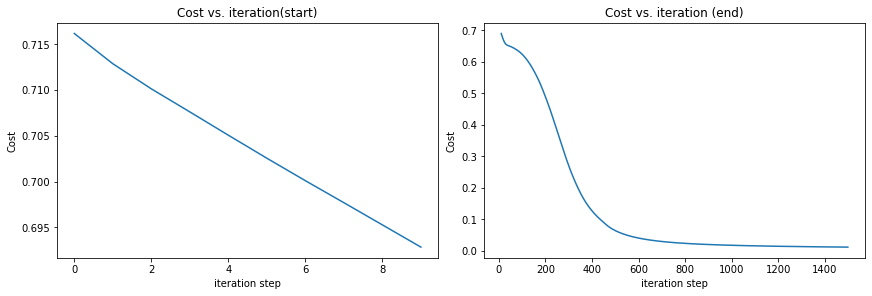

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 4. Inference

In [12]:
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)

    # auc
    print(f'auc score: {auc(fpr, tpr):.3f}')

    # plot
    plt.plot(fpr, tpr, linestyle='--', label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc=4)
    plt.show()

def infer_dset(X, y, print_res=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Preprocess
    X_flatten = X.reshape(X.shape[0], -1)
    X_flatten = X_flatten/255.

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiLayer_FC(input_dim=X_flatten.shape[1], output_dim=1)

    model = model.to(device)
    checkpoint = torch.load(f"ckpts/ckpt_3C_NN_FC_multi_Layers_torch.ckpt")
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    # Forward
    with torch.no_grad():
        y_hat = model(torch.Tensor(X_flatten).to(device))
        y_hat = y_hat.cpu().numpy().reshape(-1)

    # Accuracy
    accuracy = np.mean((y_hat >= 0.5) == y)*100.0
    print(f"Accuracy = {accuracy:.2f}%")
    
    # AUC
    plot_ROC(y, y_hat)

train_x_orig.shape = (209, 64, 64, 3) train_y.shape = (209,)
Accuracy = 100.00%
auc score: 1.000


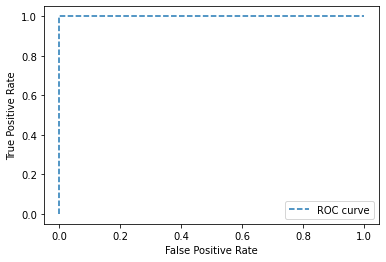

In [13]:
print(f'{train_x_orig.shape = }', f'{train_y.shape = }')
infer_dset(train_x_orig, train_y)

test_x_orig.shape = (50, 64, 64, 3) test_y.shape = (50,)
Accuracy = 76.00%
auc score: 0.733


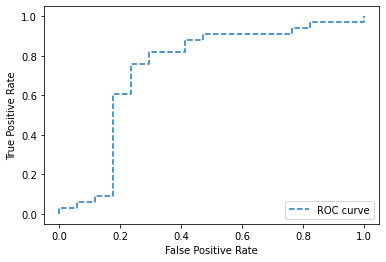

In [14]:
print(f'{test_x_orig.shape = }', f'{test_y.shape = }')
infer_dset(test_x_orig, test_y)